# **Automatic tool for temporal muscle thickness measurement**




This notebook serves as a comprehensive guide for the automatic measurement of temporalis muscle thickness (TMT) from computed tomography (CT) images. Based on a pipeline developed in our research, this guide walks through the steps involved in processing CT images to extract relevant measurements from the temporal muscle region. The focus of the project is to implement a reproducible workflow for analyzing CT scans, specifically for medical applications where muscle thickness is a critical parameter for diagnosing and monitoring neurological and musculoskeletal health.


This notebook covers:
*   Environment setup
*   Preliminary functions
*   Data load
*   Measurement
*   Model evaluation

---

**Introduction**

Temporal muscle thickness (TMT) has become a reliable and accessible biomarker for assessing muscle mass and quality, with clinical applications. This biomarker can be directly measured in cranial computed tomography (CT) scans, a routine and widely used study, making it particularly valuable for monitoring patients' nutritional and functional status. However, TMT measurement in clinical practice is performed manually, relying on the operator's experience and subject to inter-observer variation. These limitations motivated the development of an automated solution using deep learning and image processing techniques for measuring TMT in CT images.

---
**What does the tool do?**

The tool automates the process typically performed by a radiologist to perform TMT on a CT image. This automation was divided into three sections that replicate the manual process: head reorientation, axial slice selection, and segmentation and thickness measurement of the temporalis muscle.



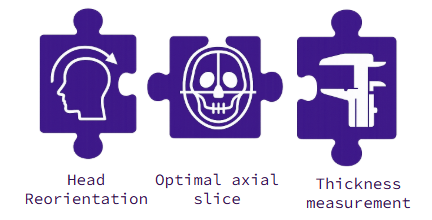


---

# **Reproducibility guide**


##**1. Enviroment Setup**

---

### A) Install

Es esencial instalar dos programas en el sistema para garantizar el correcto funcionamiento del entorno de desarrollo:

1.   Python 3.13.0: Esta versión específica del lenguaje es crucial para asegurar la compatibilidad con las bibliotecas utilizadas en el proyecto.
<button onclick="https://www.python.org/downloads/release/python-3130/';">Haz clic aquí para ir al enlace</button>

https://www.python.org/downloads/release/python-3130/
2.   Anaconda: Facilita la gestión de entornos virtuales y dependencias, asegurando que cada proyecto esté aislado y debidamente organizado.

Es importante seguir este orden de instalación, ya que estos programas son la base sobre la cual se configurará el entorno de desarrollo y se instalarán las bibliotecas necesarias para el proyecto.




### B) Create environment with conda


### C) Install requirements manually in the conda prompt using pip


### D) Select the Kernel in VS Code

## **2. Preliminary Functions**


---



##**3. Data load**



---



Once the environment has been established and the functions to be used have been imported and defined, in this subsection you must define the path to the patient's DICOM files you wish to analyze and their respective tags. Also, in this first public version of this tool, you must select the depth of the axial slice you wish to analyze. For example:

In [ ]:
ruta_archivo=r"C:\Users\kevin\OneDrive\Documentos\PROCESAMIENTO DE IMAGENES\Project\CQ-500 BASE DE DATOS\CQ500_thin\CQ500_thin\CQ500CT30 CQ500CT30\Unknown Study\CT PLAIN THIN"

# **Funciones**
Esta sección contiene las funciones implementadas para la medición automática del musculo temporal, el usuario debe ejecutar la siguiente celda para el correcto funcionamiento del programa.

In [ ]:
import nibabel as nib
from nibabel.orientations import axcodes2ornt, ornt_transform, io_orientation, apply_orientation
from nibabel.processing import resample_to_output
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d
from sklearn.cluster import KMeans
from skimage.draw import line
import json
import os
import pandas as pd
from IPython.display import display
import SimpleITK as sitk
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation as R


# === Función principal
def tempthick(ruta,tipo):
  ## === 0. Reorentación craneal
  if tipo=="dcm":
    volumen = cargar_volumen_estandar(ruta)
    mostrar_vistas_multiplanares(volumen, "Original") # Vistas coordenadas antómicas originales

    ang_x=proyectar_plano(volumen, "YZ") # PCA
    ang_y=proyectar_plano(volumen, "XZ")
    ang_z=proyectar_plano(volumen, "XY")

    if ang_y > 90:
            ang_y = 90 - ang_y # Correción ángulo
    else:
            ang_y = -ang_y

    print(f"Inclinación eje X: {ang_x:.2f}°")
    rot_x = obtener_rotacion_eje_x(-ang_x)
    volumen = aplicar_rotacion(volumen, rot_x)
    mostrar_vistas_multiplanares(volumen, "Tras eje X")

    print(f"Inclinación eje Y: {ang_y:.2f}°")
    rot_y = obtener_rotacion_eje_y(ang_y)
    volumen = aplicar_rotacion(volumen, rot_y)
    mostrar_vistas_multiplanares(volumen, "Tras eje Y")

    print(f"Rotación eje Z: {90-ang_z:.2f}°")
    rot_z = obtener_rotacion_eje_z(90 - ang_z)
    volumen = aplicar_rotacion(volumen, rot_z)
    mostrar_vistas_multiplanares(volumen, "Corregido final")

    corte=guardar_corte_axial(volumen)
  elif tipo == "volumen":
    if not os.path.exists(ruta):
        raise FileNotFoundError(f"No se encontró: {ruta}")
    out_img, k = axial_center_slice_as_nifti_resampled(ruta)
    nib.save(out_img, "paciente.nii.gz")

  ## === 1. Carga y preprocesamiento de imágenes CT
  if tipo == "corte":
     ruta_corte=ruta
  else:
     ruta_corte="paciente.nii.gz"
  data = nib.load(ruta_corte)
  data = reorient_to_ras(data)
  izquierda=data[:,:data.shape[1]//2,0]
  derecha=data[:,data.shape[1]//2:,0]
  if np.sum(izquierda)>np.sum(derecha):
    data = np.rot90(data, k=1)
  else:
    data = np.rot90(data, k=-1)
  data = np.fliplr(data)
  data = ventana(data, nivel=50, ancho=100) # Umbralizado en escala Hounsfield para tejidos blandos y oseos
  data=np.float64(data[:,:,0]/255)

  ## === 2. Identificación automatica de regiones oseas y musculares de la imagen CT
  #mascaras
  mask_hueso,mask_musculo=csegments(data, 3)
  mask_hueso=mask_hueso.astype(np.uint8)
  mask_musculo=mask_musculo.astype(np.uint8)

  # escoger solo la sección múscular temporal de la mascara
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_musculo, connectivity=8)
  areas=stats[1::,4]
  areas_org=np.sort(areas)
  areas_musc=areas_org[areas_org.shape[0]-3:areas_org.shape[0]-1]
  indice1=np.where(areas==areas_musc[0])[0][0]+1
  indice2=np.where(areas==areas_musc[1])[0][0]+1
  mask1=np.zeros(mask_musculo.shape)
  mask2=np.zeros(mask_musculo.shape)
  mask1=mask1.astype(np.uint8)
  mask2=mask2.astype(np.uint8)
  mask1[labels==indice1]=1
  mask2[labels==indice2]=1
  mask_musculo=mask1+mask2

  # rellenado de huecos
  mask_musculo=closing(mask_musculo, np.ones((3,3)))
  mask_musculo2=mask_musculo

  # escoger solo la sección craneal de la mascara
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_hueso, connectivity=8)
  areas=stats[1::,4]
  indice_max_area=np.argmax(areas)+1
  mask=np.zeros(mask_hueso.shape)
  mask[labels==indice_max_area]=1
  mask_hueso=mask

  # suavizado de la mascara craneal
  mask_hueso=mask_hueso-mask_musculo
  mask_hueso[mask_hueso<0]=0
  mask_musculo=mask_musculo2

  ## === 3. Trazado de la linea tangencial ===
  p1,p2=punto_mas_arriba_e_izquierda(mask_hueso)
  p1D,p2D=punto_mas_arriba_y_derecha(mask_hueso)

  if p1 is None or p2 is None or p1D is None or p2D is None:
     print("Error: No se pudieron encontrar puntos válidos")
     return None, None, None, None, None, None, None, None, None, 0, None, 0, None

  ## === 4. Cálculo del grosor del músculo===
  mejor_longitudI, mejor_lineaI = calcular_grosor_musculo(p1, p2, mask_musculo)
  mejor_longitudD, mejor_lineaD = calcular_grosor_musculo(p1D, p2D,mask_musculo)

  # === Visualización unificada ===
  fig, axs = plt.subplots(1, 6, figsize=(18, 4))  # 6 columnas

  # 1. Imagen original
  axs[0].imshow(data, cmap='gray')
  axs[0].set_title('Original')
  axs[0].axis('off')

  # 2. Cráneo
  axs[1].imshow(mask_hueso, cmap='gray')
  axs[1].set_title('Cráneo')
  axs[1].axis('off')

  # 3. Músculo
  axs[2].imshow(mask_musculo, cmap='gray')
  axs[2].set_title('Músculo')
  axs[2].axis('off')

  # 4. Cráneo segmentado
  axs[3].imshow(showseg(data, mask_hueso))
  axs[3].set_title('Segmento óseo')
  axs[3].axis('off')

  # 5. Músculo segmentado
  axs[4].imshow(showseg(data, mask_musculo))
  axs[4].set_title('Segmento muscular')
  axs[4].axis('off')

  # 6. Tangentes y medidas automáticas
  axs[5].imshow(data, cmap='gray')
  axs[5].set_title('Medidas automáticas')

  # Tangentes
  axs[5].plot([p1[0], p2[0]], [p1[1], p2[1]], color='green', linewidth=1, label='Tangente der')
  axs[5].plot([p1D[0], p2D[0]], [p1D[1], p2D[1]], color='pink', linewidth=1, label='Tangente izq')

  # Perpendiculares
  if mejor_lineaI is not None:
      (inicio, fin) = mejor_lineaI
      axs[5].plot([inicio[0], fin[0]], [inicio[1], fin[1]], color='red', linewidth=1,
                  label=f'Der: {mejor_longitudI:.1f} mm')
      axs[5].text(inicio[0], inicio[1] - 10, f"{mejor_longitudI:.1f} mm", color='red', fontsize=8)

  if mejor_lineaD is not None:
      (inicio, fin) = mejor_lineaD
      axs[5].plot([inicio[0], fin[0]], [inicio[1], fin[1]], color='blue', linewidth=1,
                  label=f'Izq: {mejor_longitudD:.1f} mm')
      axs[5].text(inicio[0], inicio[1] - 10, f"{mejor_longitudD:.1f} mm", color='blue', fontsize=8)

  axs[5].legend(fontsize=6, loc='lower right')
  axs[5].axis('off')

  plt.tight_layout()
  plt.show()

  eliminar_nii_gz()
  return data, mask_hueso, mask_musculo, p1, p2, p1D, p2D,mejor_longitudI, mejor_lineaI, mejor_longitudD, mejor_lineaD

# === Procesamiento de volumen .nii.gz y exportación de corte axial central
def _scale_to_uint8(a: np.ndarray) -> np.ndarray:
    a = np.asarray(a, dtype=np.float32)
    lo, hi = np.percentile(a, [1, 99])
    if hi <= lo:
        lo, hi = float(a.min()), float(a.max())
        if hi <= lo:
            return np.zeros_like(a, dtype=np.uint8)
    a = np.clip((a - lo) / (hi - lo), 0, 1)
    return (a * 255).astype(np.uint8)

def axial_center_slice_as_nifti_resampled(in_path: str) -> tuple[nib.Nifti1Image, int]:
    # 1) Cargar
    img = nib.load(in_path)

    # 2) Reorientar a RAS+ (permuta/ejes/signos) para consistencia
    img_ras = nib.as_closest_canonical(img)

    # 3) (Clave) Resamplear a un grid ortogonal (harden): affine diagonal con mismos voxel sizes
    vox = img_ras.header.get_zooms()[:3]
    img_res = resample_to_output(img_ras, voxel_sizes=vox, order=1)  # lineal

    data = img_res.get_fdata(dtype=np.float32)

    # 4) Si es 4D, tomar el primer volumen
    if data.ndim == 4 and TAKE_FIRST_4D:
        data = data[..., 0]

    # 5) Axial central (k)
    k = data.shape[2] // 2
    slice3d = data[:, :, k][..., np.newaxis]  # (X, Y, 1)

    # 6) Ajustar affine para que el plano (i,j,0) caiga en la misma posición física del k
    A = img_res.affine.copy()
    A[:3, 3] = A[:3, 3] + A[:3, 2] * k

    hdr = img_res.header.copy()
    hdr.set_data_shape(slice3d.shape)
    hdr.set_zooms(img_res.header.get_zooms()[:3])

    out_img = nib.Nifti1Image(slice3d, A, header=hdr)
    return out_img, k

# === Cargar volumen DICOM orientado
def cargar_volumen_estandar(dicom_folder):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_folder)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return sitk.DICOMOrient(image, "RAI")

# === Obtener matrices de orientación
def obtener_matriz_orientacion(volumen):
  matriz = np.array(volumen.GetDirection()).reshape(3, 3)
  return matriz

# === Mostrar vistas axiales, coronales y sagitales
def mostrar_vistas_multiplanares(vol_sitk, titulo="Volumen"):
    array = sitk.GetArrayFromImage(vol_sitk)
    z, y, x = array.shape[0] // 2, array.shape[1] // 2, array.shape[2] // 2
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(array[z], cmap='gray'); axs[0].set_title(f"{titulo} - Axial")
    axs[1].imshow(array[:, y, :], cmap='gray'); axs[1].set_title("Coronal")
    axs[2].imshow(array[:, :, x], cmap='gray'); axs[2].set_title("Sagital")
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Funciones de PCA por plano
def obtener_angulo_inclinacion_sagital(volume_sitk, hu_umbral=300):
    array = sitk.GetArrayFromImage(volume_sitk)  # (Z,Y,X)
    binario = array > hu_umbral
    coords = np.argwhere(binario)
    yz_coords = coords[:, [1, 0]]  # (Y,Z)
    pca = PCA(n_components=2).fit(yz_coords)
    comp = pca.components_[0]
    angulo = np.degrees(np.arctan2(comp[1], comp[0]))
    return angulo

def obtener_angulo_inclinacion_lateral(volume_sitk, hu_umbral=300):
    array = sitk.GetArrayFromImage(volume_sitk)
    binario = array > hu_umbral
    coords = np.argwhere(binario)
    xz_coords = coords[:, [2, 0]]  # (X,Z)
    pca = PCA(n_components=2).fit(xz_coords)
    comp = pca.components_[0]
    angulo = np.degrees(np.arctan2(comp[1], comp[0]))
    return angulo

def obtener_angulo_rotacion_axial(volume_sitk, hu_umbral=300):
    array = sitk.GetArrayFromImage(volume_sitk)
    binario = array > hu_umbral
    coords = np.argwhere(binario)
    xy_coords = coords[:, [2, 1]]  # (X,Y)
    pca = PCA(n_components=2).fit(xy_coords)
    comp = pca.components_[0]
    angulo = np.degrees(np.arctan2(comp[1], comp[0]))
    return angulo

# === Proyección PCA visual clara
def proyectar_plano(volume_sitk, plano="YZ", hu_umbral=300):
    array = sitk.GetArrayFromImage(volume_sitk)  # (Z,Y,X)
    binario = array > hu_umbral
    coords = np.argwhere(binario)

    if plano == "YZ":
        proj_coords = coords[:, [1, 0]]
        imagen_proj = np.sum(binario, axis=2)  # sum sobre X
        xlabel, ylabel = 'Y', 'Z'
    elif plano == "XZ":
        proj_coords = coords[:, [2, 0]]
        imagen_proj = np.sum(binario, axis=1)  # sum sobre Y
        xlabel, ylabel = 'X', 'Z'
    elif plano == "XY":
        proj_coords = coords[:, [2, 1]]
        imagen_proj = np.sum(binario, axis=0)  # sum sobre Z
        xlabel, ylabel = 'X', 'Y'
    else:
        raise ValueError("Plano no válido")

    pca = PCA(n_components=2)
    pca.fit(proj_coords)
    v = pca.components_[0]
    centro = np.mean(proj_coords, axis=0)
    angulo = np.degrees(np.arctan2(v[1], v[0]))

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(imagen_proj.T, cmap='gray', origin='lower')
    ax.set_title(f"Proyección {plano} + PCA\nÁngulo: {angulo:.2f}°")
    p1 = centro - v * 100
    p2 = centro + v * 100
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='red', linewidth=2)
    ax.scatter(*centro, color='yellow')
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    plt.tight_layout(); plt.show()
    return angulo

# === Matrices de rotación
def obtener_rotacion_eje_x(angulo):
    t = -np.radians(angulo)
    return np.array([[1, 0, 0], [0, np.cos(t), -np.sin(t)], [0, np.sin(t), np.cos(t)]])

def obtener_rotacion_eje_y(angulo):
    t = -np.radians(angulo)
    return np.array([[np.cos(t), 0, np.sin(t)], [0, 1, 0], [-np.sin(t), 0, np.cos(t)]])

def obtener_rotacion_eje_z(angulo):
    t = -np.radians(angulo)
    return np.array([[np.cos(t), -np.sin(t), 0], [np.sin(t), np.cos(t), 0], [0, 0, 1]])

# === Aplicar rotación al volumen
def aplicar_rotacion(volume_sitk, rot_matrix):
    size = volume_sitk.GetSize()
    center_voxel = np.array(size[::-1]) / 2.0
    center_phys = volume_sitk.TransformContinuousIndexToPhysicalPoint(center_voxel.tolist())

    transform = sitk.AffineTransform(3)
    transform.SetCenter(center_phys)
    transform.SetMatrix(rot_matrix.flatten().tolist())

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(volume_sitk)
    resampler.SetTransform(transform)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(-1024)

    return resampler.Execute(volume_sitk)

# === Exportar un solo corte axial como .nii.gz
def guardar_corte_axial(vol_sitk):
    array = sitk.GetArrayFromImage(vol_sitk)
    corte = array[array.shape[0] // 2]  # Corte axial central

    # Crear imagen 2D
    corte_img = sitk.GetImageFromArray(corte)

    # Copiar propiedades espaciales relevantes (opcional)
    corte_img.SetSpacing(vol_sitk.GetSpacing()[1:])  # Espaciado (y, x)
    corte_img.SetOrigin((0.0, 0.0))
    corte_img.SetDirection([1.0, 0.0, 0.0, 1.0])  # identidad para 2D

    # Guardar
    sitk.WriteImage(corte_img, "paciente.nii.gz")

# === Reorientación de los datos cargados
def reorient_to_ras(img):
    orig_ornt = io_orientation(img.affine)
    ras_ornt = axcodes2ornt(('R', 'A', 'S'))
    transform = ornt_transform(orig_ornt, ras_ornt)
    data = img.get_fdata()
    if data.ndim == 2:
      data = data[:, :, np.newaxis]
    reoriented_data = apply_orientation(data, transform)
    return reoriented_data

# === Rellenado Huecos
def closing(img,s):
  img=cv2.dilate(img,s)
  #img=cv2.erode(img,s)
  img = cv2.GaussianBlur(img, (9,9), sigmaX=1)
  return img

# === Umbralizado en escalas hounsfield
def ventana(imagen, nivel, ancho):
    min_val = nivel - (ancho / 2)
    max_val = nivel + (ancho / 2)
    ventana = np.clip(imagen, min_val, max_val)
    ventana = np.float64((ventana - min_val) / (max_val - min_val) * 255)
    return ventana.astype(np.uint8)

# === Coloreado de Verde a una mascara
def showseg(f, mask):
  if f.ndim==2:
    f_red = 0.8*f
    f_blue = 0.8*f
    f_green = np.clip(0.8*f + mask.astype(f.dtype), 0, 1)
    g = np.dstack((f_red, f_green, f_blue))
  elif f.ndim==3:
    f[:,:,1] = np.clip(f[:,:,1]+0.8*mask.astype(f.dtype), 0, 1)
    g = f
  return g

# === Separar en 3 regiones (2 finalmente utilizadas)
def csegments(f, nclusters):
  if f.ndim==2:
    f=np.dstack((f,f,f))
  X=f.reshape(-1,3)
  kmeans = KMeans(n_clusters=nclusters,random_state=42, n_init=10)
  kmeans.fit(X)
  centros=kmeans.cluster_centers_
  R=np.zeros((f.shape[0],f.shape[1]))
  for j in range(f.shape[0]):
    for k in range(f.shape[1]):
      resta=[]
      for i in range(centros.shape[0]):
        resta.append(np.linalg.norm(f[j,k,:]-centros[i,:]))
      R[j,k]=np.argmin(resta)+1

  #Conteo de pixeles para region osea
  a=0
  b=0
  c=0
  for i in range(R.shape[0]):
    for j in range(R.shape[1]):
      if R[i,j]==1:
        a+=1
      if R[i,j]==2:
        b+=1
      if R[i,j]==3:
        c+=1
  d=np.array([a,b,c])
  R2=np.zeros(R.shape)
  if np.min(d)==a:
    R2[R==1]=1
  elif np.min(d)==b:
    R2[R==2]=1
  else:
    R2[R==3]=1

  #Conteo de pixeles para region muscular
  a=0
  b=0
  c=0
  for i in range(R.shape[0]):
    for j in range(R.shape[1]):
      if R[i,j]==1:
        a+=1
      if R[i,j]==2:
        b+=1
      if R[i,j]==3:
        c+=1
  d=np.array([a,b,c])
  R3=np.zeros(R.shape)
  if np.median(d)==a:
    R3[R==1]=1
  elif np.median(d)==b:
    R3[R==2]=1
  else:
    R3[R==3]=1
  return R2,R3

# === Puntos tangenciales zona izquierdo de la imagen
def punto_mas_arriba_e_izquierda(mask_hueso):
    punto = np.array([-1, 1000])
    romper = False
    for i in range(0, mask_hueso.shape[0], 5):
        for j in range(mask_hueso.shape[1]):
            if mask_hueso[i, j] == 1:
                if i > punto[0] and j < punto[1]:
                    punto = np.array([i, j])
                    break
                elif i > punto[0] and j > punto[1]:
                    romper = True
        if romper:
            break
    num=100
    punto2=np.array([0,0])
    for i in range(mask_hueso.shape[0]-1,punto[0]+20,-1):
      for j in range(mask_hueso.shape[1]):
        if mask_hueso[i,j]==1:
          puntor=np.array([i,j])
          rr,cc=line(punto[0],punto[1],puntor[0],puntor[1])
          valores=mask_hueso[rr,cc]
          valores=valores[mask_hueso[rr,cc]==1]
          if len(valores)<num:
            num=len(valores)
            punto2=puntor
          else:
            break
    return np.array([punto[1], punto[0]]),np.array([punto2[1], punto2[0]]) # Formato (x, y)


# === Puntos tangenciales zona derecho de la imagen
def punto_mas_arriba_y_derecha(mask_hueso):
    punto = np.array([-1, -1])
    romper = False
    for i in range(0, mask_hueso.shape[0], 5):
        for j in range(mask_hueso.shape[1]-1, 0, -1):
            if mask_hueso[i, j] == 1:
                if i > punto[0] and j > punto[1]:
                    punto = np.array([i, j])
                    break
                elif i > punto[0] and j < punto[1]:
                    romper = True
        if romper:
            break
    num=100
    punto2=np.array([0,0])
    for i in range(mask_hueso.shape[0]-1,punto[0]+20,-1):
      for j in range(mask_hueso.shape[1]-1,0,-1):
        if mask_hueso[i,j]==1:
          puntor=np.array([i,j])
          rr,cc=line(punto[0],punto[1],puntor[0],puntor[1])
          valores=mask_hueso[rr,cc]
          valores=valores[mask_hueso[rr,cc]==1]
          if len(valores)<num:
            num=len(valores)
            punto2=puntor
          else:
            break
    return np.array([punto[1], punto[0]]),np.array([punto2[1], punto2[0]])

# === Lineas perpendiculares y cálculo del grosor
def calcular_grosor_musculo(p1, p2, mask_musculo, pixel_spacing=(0.5, 0.5), N=100, L=100, extension_factor=1.2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    v_tan = p2 - p1
    v_tan = v_tan / np.linalg.norm(v_tan)
    v_perp = np.array([-v_tan[1], v_tan[0]])

    # Punto extendido más allá de p2
    extension_length = np.linalg.norm(p2 - p1) * extension_factor
    p3_extendido = p1 + v_tan * extension_length

    # Generar puntos a lo largo de la línea extendida
    puntos = [p1 + t * (p3_extendido - p1) / N for t in range(N)]

    mejor_longitud = 0
    mejor_linea = None
    mejor_longitud_mm = 0.0

    alto_mm, ancho_mm = pixel_spacing

    for punto in puntos:
        punto = np.round(punto).astype(int)
        inicio = np.round(punto - L*v_perp).astype(int)
        fin    = np.round(punto + L*v_perp).astype(int)

        rr, cc = line(inicio[1], inicio[0], fin[1], fin[0])
        rr = np.clip(rr, 0, mask_musculo.shape[0]-1)
        cc = np.clip(cc, 0, mask_musculo.shape[1]-1)

        valores = mask_musculo[rr, cc].astype(bool)
        indices_en_mascara = np.where(valores)[0]

        if len(indices_en_mascara) >= 2:
            idx_inicio = indices_en_mascara[0]
            idx_fin = indices_en_mascara[-1]

            y0, x0 = rr[idx_inicio], cc[idx_inicio]
            y1, x1 = rr[idx_fin], cc[idx_fin]

            dx = (x1 - x0) * ancho_mm
            dy = (y1 - y0) * alto_mm
            distancia_mm = np.sqrt(dx**2 + dy**2)

            if distancia_mm > mejor_longitud_mm:
                mejor_longitud = idx_fin - idx_inicio + 1
                mejor_longitud_mm = distancia_mm
                mejor_linea = ((x0, y0), (x1, y1))

    return mejor_longitud_mm, mejor_linea

# === Procesamiento de resultados y proyección en tabla de resultados
def procesar_archivo(ruta_archivo,tipo):
    try:
        nombre_archivo = os.path.basename(ruta_archivo).split(".")[0]

        # Ejecuta análisis
        _, _, _, p1, p2, p1D, p2D, mejor_longitudI, _, mejor_longitudD, _ = tempthick(ruta_archivo,tipo)

        # Promedio de los dos grosores
        grosor_promedio = (mejor_longitudI + mejor_longitudD) / 2

        # Puedes guardar cualquier info relevante. Aquí: nombre, puntos, grosor
        fila = {
            "scan": nombre_archivo,
            "coordenadas_izq": f"{p1} a {p2}",
            "coordenadas_der": f"{p1D} a {p2D}",
            "grosor_izquierdo": round(mejor_longitudI, 2),
            "grosor_derecho": round(mejor_longitudD, 2),
            "grosor_promedio": round(grosor_promedio, 2)
        }

    except Exception as e:
        fila = {
            "scan": os.path.basename(ruta_archivo),
            "coordenadas_izq": "error",
            "coordenadas_der": "error",
            "grosor_izquierdo": "error",
            "grosor_derecho": "error",
            "grosor_promedio": "error"
        }
        print(f"Error procesando {ruta_archivo}: {e}")

    return pd.DataFrame([fila])


# === Procesamiento de resultados para un directorio y proyección en tabla de resultados
def analizar_directorio(directorio):
    archivos = [os.path.join(directorio, f) for f in os.listdir(directorio) if f.endswith(".nii.gz")]
    resultados = pd.DataFrame()
    for archivo in archivos:
        print(f"Procesando: {archivo}")
        df = procesar_archivo(archivo)
        resultados = pd.concat([resultados, df], ignore_index=True)
    return resultados

## === Funciones para calcular errores
def leer_medida_referencia(archivo_json):
    """
    Lee un archivo .mrk.json y extrae la medida de longitud (espesor del músculo).

    Args:
        archivo_json (str): Ruta al archivo .mrk.json

    Returns:
        float: Medida de longitud en mm, o None si hay error
    """
    try:
        with open(archivo_json, 'r', encoding='utf-8') as f:
            data = json.load(f)

        # Navegar por la estructura JSON para obtener la medida
        markups = data.get('markups', [])
        if markups:
            measurements = markups[0].get('measurements', [])
            for measurement in measurements:
                if measurement.get('name') == 'length':
                    return measurement.get('value')
        return None

    except Exception as e:
        print(f"Error leyendo {archivo_json}: {e}")
        return None

def obtener_medidas_referencia(directorio_marks):
    """
    Obtiene todas las medidas de referencia de la carpeta marks.

    Args:
        directorio_marks (str): Ruta al directorio que contiene los archivos .mrk.json

    Returns:
        dict: Diccionario con las medidas organizadas por imagen y lado
              Ejemplo: {'3': {'L': 6.435, 'R': 5.491}, '148': {'L': 7.2, 'R': 6.8}}
    """
    medidas_referencia = {}

    # Listar todos los archivos .mrk.json
    archivos_json = [f for f in os.listdir(directorio_marks) if f.endswith('.mrk.json')]

    for archivo in archivos_json:
        ruta_completa = os.path.join(directorio_marks, archivo)

        # Extraer número de imagen y lado del nombre del archivo
        # Ejemplo: "3L.mrk.json" -> imagen="3", lado="L"
        nombre_base = archivo.replace('.mrk.json', '')
        if len(nombre_base) > 0 and nombre_base[-1] in ['L', 'R']:
            lado = nombre_base[-1]
            imagen = nombre_base[:-1]

            # Leer la medida
            medida = leer_medida_referencia(ruta_completa)

            if medida is not None:
                if imagen not in medidas_referencia:
                    medidas_referencia[imagen] = {}
                medidas_referencia[imagen][lado] = medida
                print(f"Cargada medida: {archivo} -> Imagen {imagen}, Lado {lado}: {medida:.3f} mm")

    print(f"\nTotal de archivos .mrk.json encontrados: {len(archivos_json)}")
    print(f"Imágenes con medidas cargadas: {len(medidas_referencia)}")

    return medidas_referencia

def calcular_errores(df_resultados, medidas_referencia):
    """
    Calcula los errores entre las medidas del algoritmo y las de referencia.

    Args:
        df_resultados (pd.DataFrame): DataFrame con los resultados del algoritmo
        medidas_referencia (dict): Diccionario con las medidas de referencia

    Returns:
        pd.DataFrame: DataFrame con los errores calculados
    """
    errores_data = []

    for index, row in df_resultados.iterrows():
        # Extraer el número de la imagen del nombre del scan
        scan_name = str(row['scan'])
        # Remover extensiones y obtener solo el número
        imagen_num = scan_name.replace('.nii', '').replace('.gz', '')

        # Obtener medidas del algoritmo
        alg_izq = row['grosor_izquierdo'] if row['grosor_izquierdo'] != 'error' else None
        alg_der = row['grosor_derecho'] if row['grosor_derecho'] != 'error' else None
        alg_prom = row['grosor_promedio'] if row['grosor_promedio'] != 'error' else None

        # Buscar las medidas de referencia para esta imagen
        if imagen_num in medidas_referencia:
            ref_data = medidas_referencia[imagen_num]

            # Obtener medidas de referencia
            ref_izq = ref_data.get('R')
            ref_der = ref_data.get('L')
            ref_prom = None
            if ref_izq is not None and ref_der is not None:
                ref_prom = (ref_izq + ref_der) / 2

            # Calcular errores
            error_izq = None
            error_der = None
            error_prom = None
            error_abs_izq = None
            error_abs_der = None
            error_abs_prom = None
            error_rel_izq = None
            error_rel_der = None
            error_rel_prom = None

            if alg_izq is not None and ref_izq is not None:
                error_izq = alg_izq - ref_izq
                error_abs_izq = abs(error_izq)
                error_rel_izq = (error_abs_izq / ref_izq) * 100

            if alg_der is not None and ref_der is not None:
                error_der = alg_der - ref_der
                error_abs_der = abs(error_der)
                error_rel_der = (error_abs_der / ref_der) * 100

            if alg_prom is not None and ref_prom is not None:
                error_prom = alg_prom - ref_prom
                error_abs_prom = abs(error_prom)
                error_rel_prom = (error_abs_prom / ref_prom) * 100

            errores_data.append({
                'imagen': imagen_num,
                'ref_izquierdo': ref_izq,
                'alg_izquierdo': alg_izq,
                'error_izquierdo': error_izq,
                'error_abs_izquierdo': error_abs_izq,
                'error_rel_izquierdo': error_rel_izq,
                'ref_derecho': ref_der,
                'alg_derecho': alg_der,
                'error_derecho': error_der,
                'error_abs_derecho': error_abs_der,
                'error_rel_derecho': error_rel_der,
                'ref_promedio': ref_prom,
                'alg_promedio': alg_prom,
                'error_promedio': error_prom,
                'error_abs_promedio': error_abs_prom,
                'error_rel_promedio': error_rel_prom
            })
        else:
            # No se encontraron medidas de referencia para esta imagen
            errores_data.append({
                'imagen': imagen_num,
                'ref_izquierdo': None,
                'alg_izquierdo': alg_izq,
                'error_izquierdo': None,
                'error_abs_izquierdo': None,
                'error_rel_izquierdo': None,
                'ref_derecho': None,
                'alg_derecho': alg_der,
                'error_derecho': None,
                'error_abs_derecho': None,
                'error_rel_derecho': None,
                'ref_promedio': None,
                'alg_promedio': alg_prom,
                'error_promedio': None,
                'error_abs_promedio': None,
                'error_rel_promedio': None
            })

    return pd.DataFrame(errores_data)

def calcular_estadisticas_error(df_errores):
    """
    Calcula estadísticas generales del error del algoritmo.

    Args:
        df_errores (pd.DataFrame): DataFrame con los errores calculados

    Returns:
        dict: Diccionario con las estadísticas de error
    """
    estadisticas = {}

    # Filtrar valores no nulos para cada tipo de error
    for lado in ['izquierdo', 'derecho', 'promedio']:
        errores_abs = df_errores[f'error_abs_{lado}'].dropna()
        errores_rel = df_errores[f'error_rel_{lado}'].dropna()
        errores = df_errores[f'error_{lado}'].dropna()

        if len(errores_abs) > 0:
            estadisticas[f'{lado}'] = {
                'n_muestras': len(errores_abs),
                'error_absoluto_medio': errores_abs.median(),  # <- MEDIANA en vez de media
                'error_absoluto_std': errores_abs.std(),
                'error_absoluto_min': errores_abs.min(),
                'error_absoluto_max': errores_abs.max(),
                'error_relativo_medio': errores_rel.mean(),
                'error_relativo_std': errores_rel.std(),
                'error_medio': errores.mean(),
                'error_std': errores.std()
            }
        else:
            estadisticas[f'{lado}'] = {
                'n_muestras': 0,
                'error_absoluto_medio': None,
                'error_absoluto_std': None,
                'error_absoluto_min': None,
                'error_absoluto_max': None,
                'error_relativo_medio': None,
                'error_relativo_std': None,
                'error_medio': None,
                'error_std': None
            }

    return estadisticas


def imprimir_estadisticas(estadisticas):
    """
    Imprime las estadísticas de error de forma legible.

    Args:
        estadisticas (dict): Diccionario con las estadísticas
    """
    print("="*80)
    print("ESTADÍSTICAS DE ERROR DEL ALGORITMO")
    print("="*80)

    for lado, stats in estadisticas.items():
        print(f"\n--- LADO {lado.upper()} ---")
        print(f"Número de muestras: {stats['n_muestras']}")

        if stats['n_muestras'] > 0:
            print(f"Error absoluto promedio: {stats['error_absoluto_medio']:.3f} ± {stats['error_absoluto_std']:.3f} mm")
            print(f"Error absoluto rango: [{stats['error_absoluto_min']:.3f}, {stats['error_absoluto_max']:.3f}] mm")
            print(f"Error relativo promedio: {stats['error_relativo_medio']:.2f} ± {stats['error_relativo_std']:.2f} %")
            print(f"Error promedio (con signo): {stats['error_medio']:.3f} ± {stats['error_std']:.3f} mm")
        else:
            print("No hay datos disponibles")

def analizar_errores_completo(df_resultados, directorio_marks):
    """
    Realiza el análisis completo de errores.

    Args:
        df_resultados (pd.DataFrame): DataFrame con resultados del algoritmo
        directorio_marks (str): Directorio con archivos .mrk.json de referencia

    Returns:
        tuple: (df_errores, estadisticas)
    """
    print("Leyendo medidas de referencia desde archivos .mrk.json...")
    medidas_referencia = obtener_medidas_referencia(directorio_marks)
    print(f"Se encontraron medidas para {len(medidas_referencia)} imágenes")

    print("\nCalculando errores...")
    df_errores = calcular_errores(df_resultados, medidas_referencia)

    print("Calculando estadísticas...")
    estadisticas = calcular_estadisticas_error(df_errores)

    return df_errores, estadisticas

def eliminar_nii_gz(ruta_archivo="paciente.nii.gz"):
    if os.path.exists(ruta_archivo):
        try:
            os.remove(ruta_archivo)
        except Exception as e:
          pass
    else:
      pass


# **Ruta tipo DICOM del archivo a analizar o directorio a analizar**


In [ ]:
tipo = "dcm" #Si es un corte axial único tipo nii.gz poner "corte", si es un volumen tipo nii.gz "volumen" el codigo seleccionara un corte central de este volumen, si es un volumen tipo dicoom, poner "dcm", el codigo reorientara este volumen y seleccionara un corte central.
ruta_archivo = r"C:\Users\kevin\OneDrive\Documentos\PROCESAMIENTO DE IMAGENES\Project\CQ-500 BASE DE DATOS\CQ500_thin\CQ500_thin\CQ500CT30 CQ500CT30\Unknown Study\CT PLAIN THIN" #Poner la dirección hacia el archivo a analizar
directorio_imagenes = None

# **Ejecución del codigo**
El usuario debe ejecutar esta sección una vez haya definido el archivo o directorio que desee analizar. Para visualizar los resultados, se debe ejecutar la celda que lleva como título "Celda de visualización de resultados".

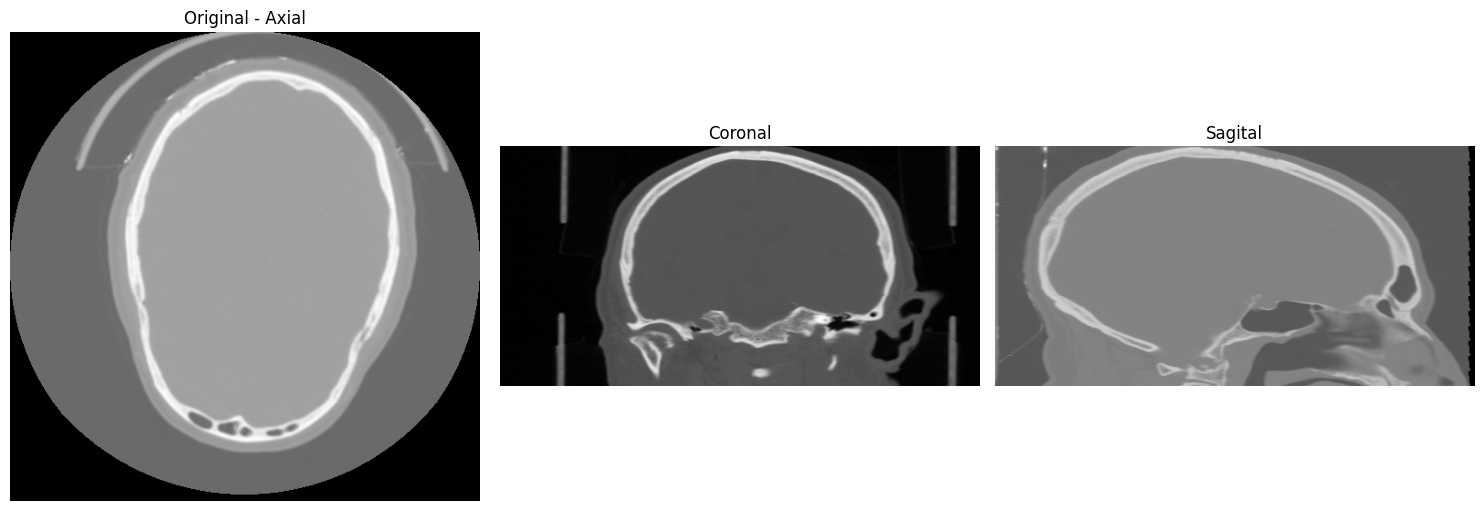

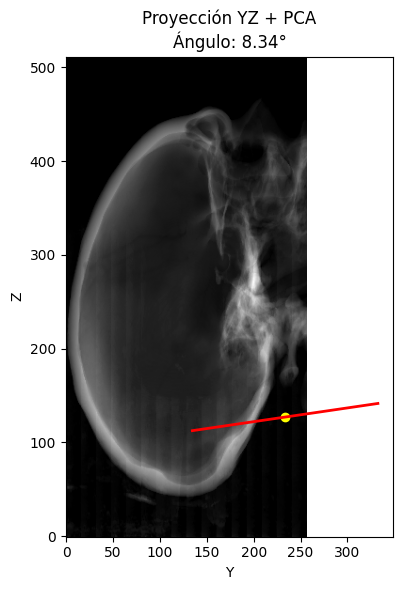

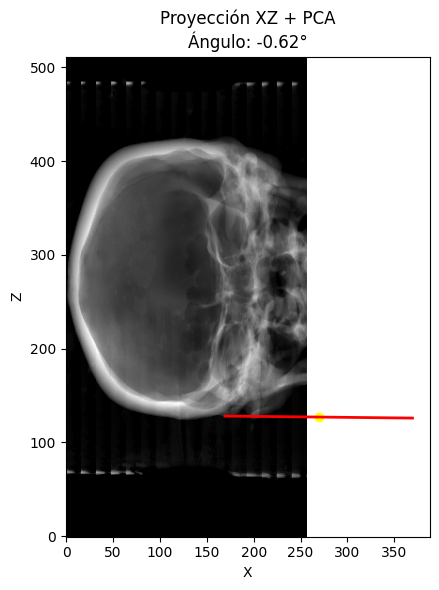

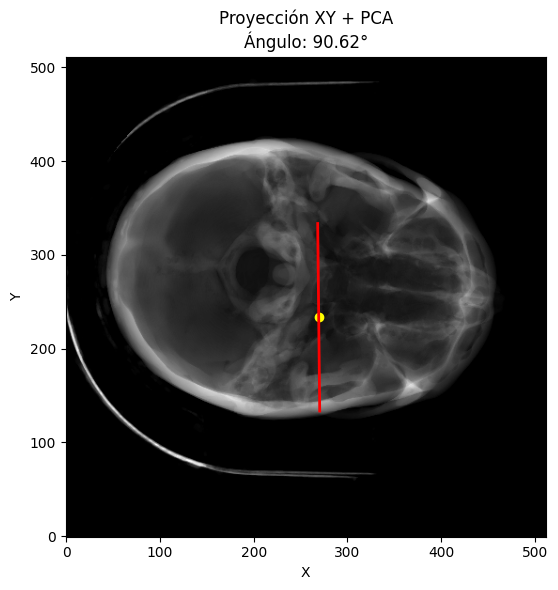

Inclinación eje X: 8.34°


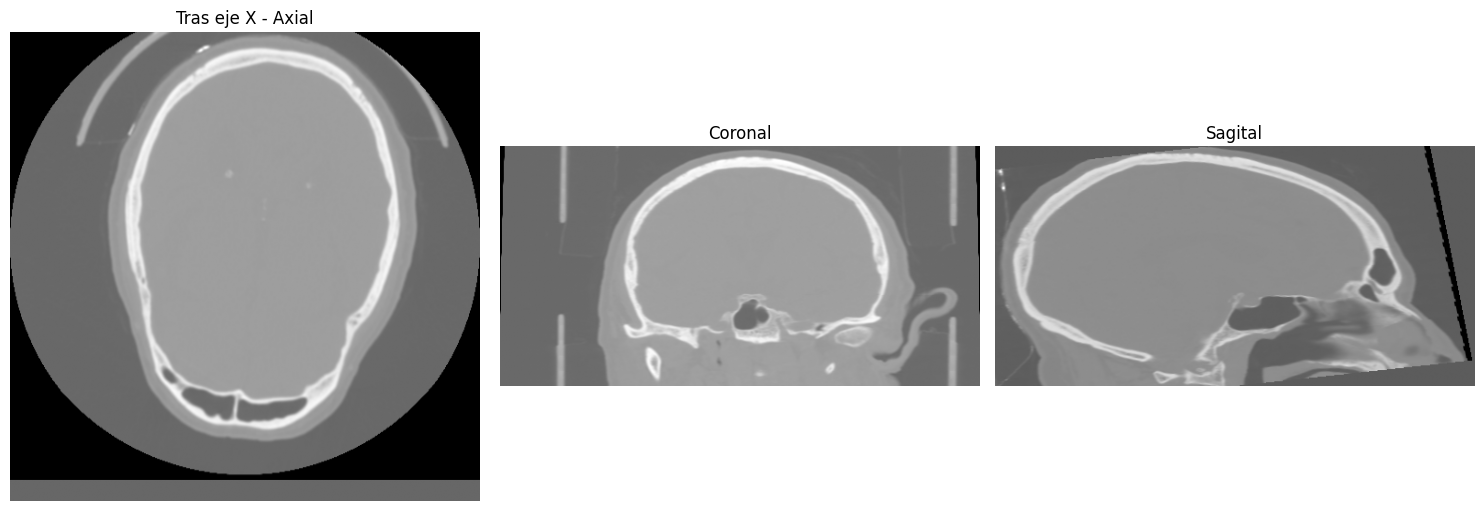

Inclinación eje Y: 0.62°


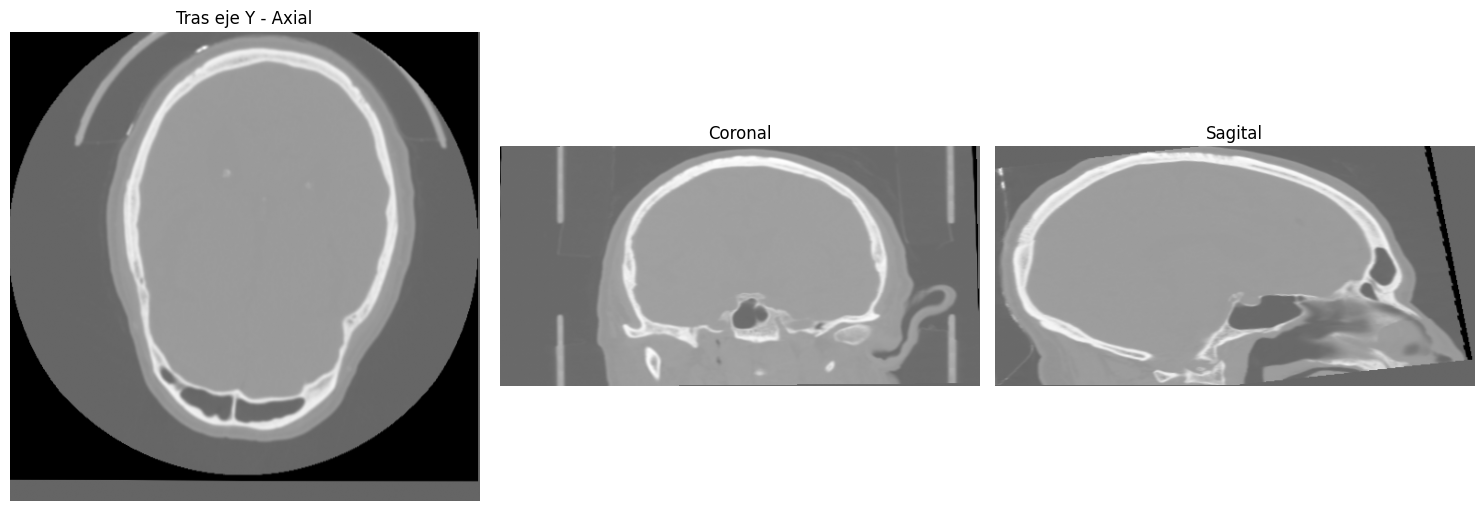

Rotación eje Z: -0.62°


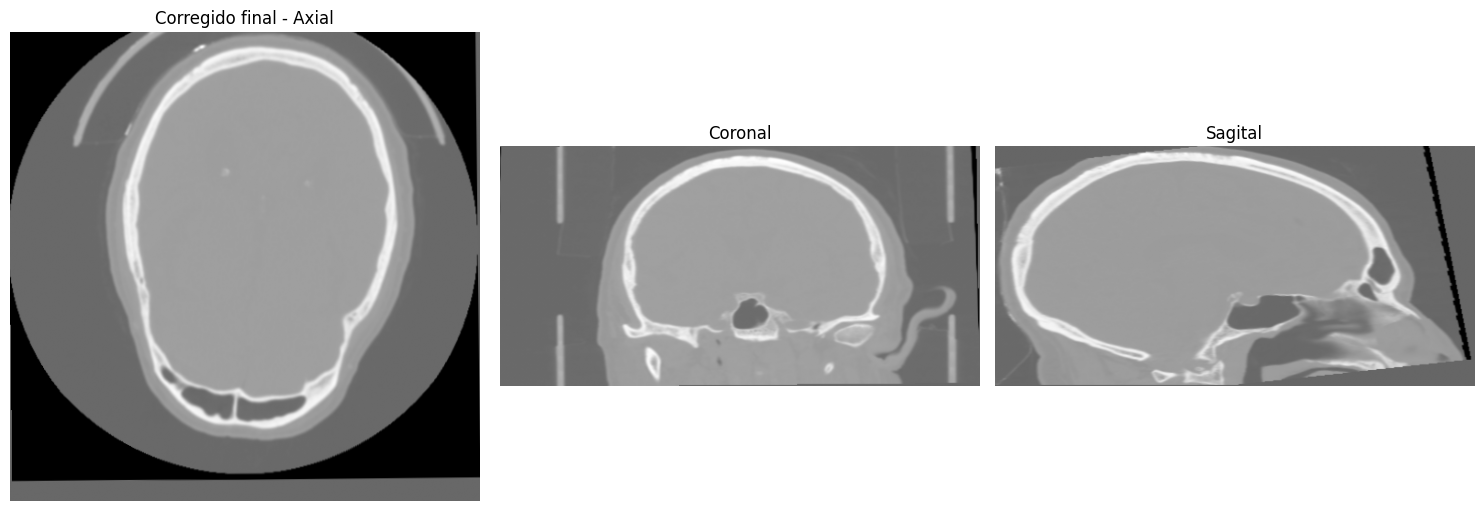

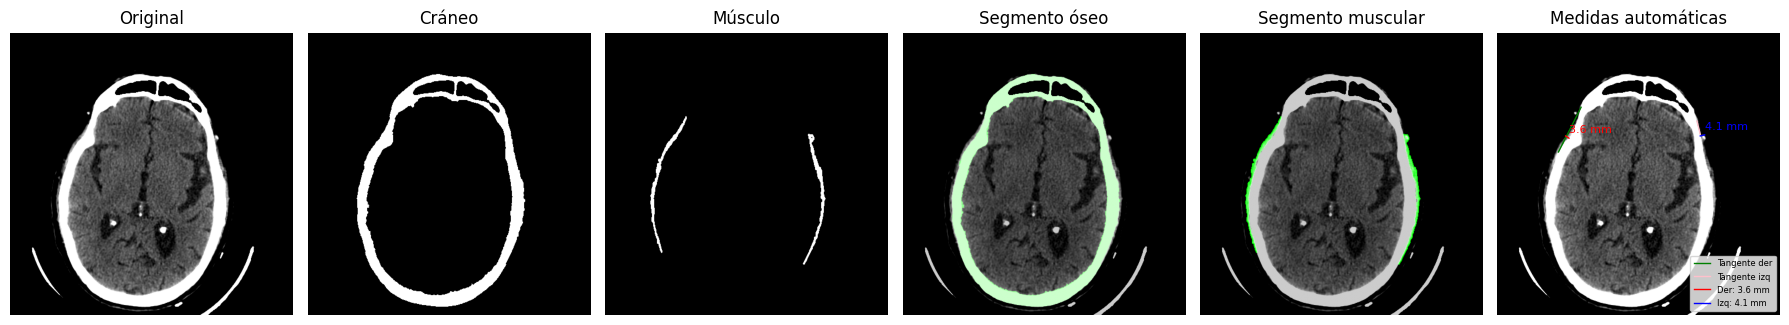

,scan,coordenadas_izq,coordenadas_der,grosor_izquierdo,grosor_derecho,grosor_promedio
0,CT PLAIN THIN,[151 135] a [110 216],[361 160] a [367 184],3.61,4.12,3.86


In [ ]:
#@title  Celda de visualización de resultados { display-mode: "form" }
if directorio_imagenes is not None:
    df_resultados = analizar_directorio(directorio_imagenes)
    df_resultados.to_csv("resultados_temporales.csv", index=False)
    display(df_resultados)
else:
  df_resultados = procesar_archivo(ruta_archivo,tipo)
  df_resultados.to_csv("resultados_temporales.csv", index=False)
  display(df_resultados)